In [136]:
import pandas as pd
import networkx as nx
from time import time
from pgmpy.models import BayesianNetwork
from sklearn.metrics import f1_score
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel
from pgmpy.estimators import K2Score, BicScore, BDeuScore
import matplotlib.pyplot as plt
from pgmpy.estimators import TreeSearch
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
import numpy as np

# Data loading
colnames=['Buying', 'Maint', 'Doors', 'Persons', 'Log_size','Safety']
data = pd.read_csv('car.data', names=colnames)
data.columns

Index(['Buying', 'Maint', 'Doors', 'Persons', 'Log_size', 'Safety'], dtype='object')

In [137]:
data.head()

,Buying,Maint,Doors,Persons,Log_size,Safety
vhigh,vhigh,2,2,small,low,unacc
vhigh,vhigh,2,2,small,med,unacc
vhigh,vhigh,2,2,small,high,unacc
vhigh,vhigh,2,2,med,low,unacc
vhigh,vhigh,2,2,med,med,unacc


In [138]:
# Funtion to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model, nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model, nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)

# Apply algorithms

In [149]:
# Tree search
t0 = time()
est = TreeSearch(data)
estimated_model = est.estimate(estimator_type="chow-liu")
t1 = time()

# Hill Climb search
scoring_method = K2Score(data=data) # higher one
est2 = HillClimbSearch(data=data)
estimated_model2 = est2.estimate(scoring_method=scoring_method, max_indegree=2) # max_indegree 2, 1 most similar but does not catch some dependencies (3 does not change anything)
t2 = time()

# Compute metric
get_f1_score(estimated_model, estimated_model2)

Building tree:   0%|          | 0/15.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

F1-score for the model skeleton:  0.7272727272727272


# Draw Structures

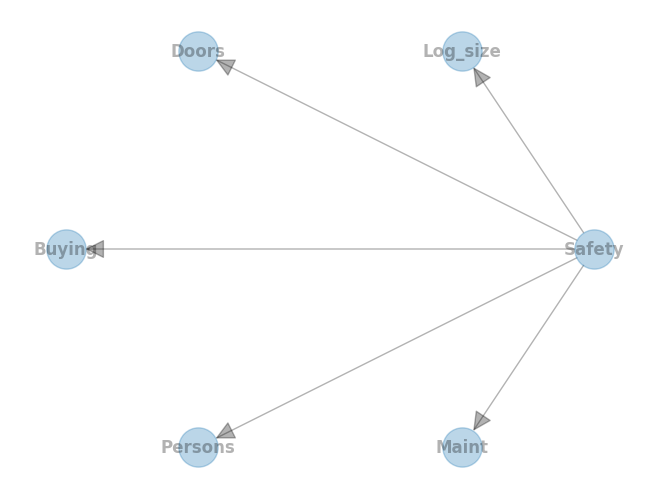

In [140]:
# Draw Tree search graph 
nx.draw_circular(
    estimated_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

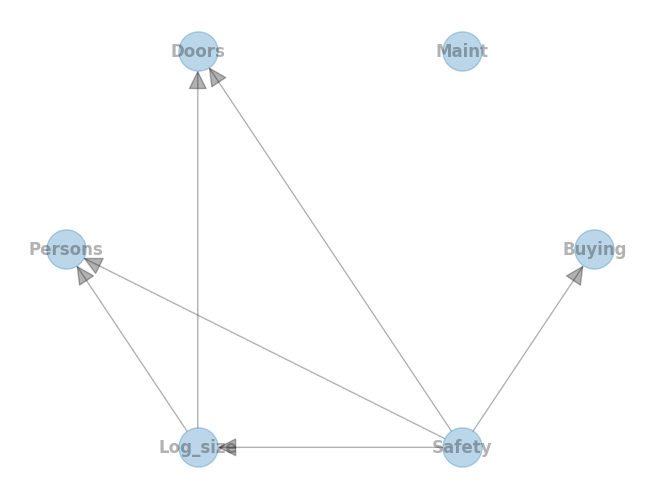

In [150]:
# Draw Hill Climb graph
nx.draw_circular(
    estimated_model2, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Identify independencies for Maint Node

## Chi2 Test

In [142]:
from pgmpy.estimators.CITests import chi_square
# true <-> independent
# false <-> dependent
 
# In line with both learned structures
print(chi_square(X='Maint', Y='Buying', Z=[], data=data, significance_level=0.01)) # independent
print(chi_square(X='Maint', Y='Doors', Z=[], data=data, significance_level=0.01)) # indipendent
print(chi_square(X='Maint', Y='Persons', Z=[], data=data, significance_level=0.01)) # independent
print(chi_square(X='Maint', Y='Log_size', Z=[], data=data, significance_level=0.01)) # independent

# But
# Safety and Maint are independent (TreeSearch identify a wrong dependency)
print(chi_square(X='Maint', Y='Safety', Z=[], data=data, significance_level=0.01)) # independent

True
True
True
True
True


In [143]:
print('TreeSearch takes %f' %(t1-t0))
print('HillClimb takes %f' %(t2-t1))

TreeSearch takes 0.056064
HillClimb takes 0.088462
